#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
path = '/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [12]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [13]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_df = pd.read_csv(path + '/data01_train.csv')
test_df = pd.read_csv(path + '/data01_test.csv')
feature_df = pd.read_csv(path + '/features.csv')

In [14]:
#불필요한 칼럼을 삭제하세요.
train_df.drop('subject', axis=1, inplace=True)
test_df.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [15]:
#전체 데이터의 행,열 개수 확인
train_df.shape, test_df.shape, feature_df.shape

((5881, 562), (1471, 562), (561, 4))

In [16]:
#전체 데이터의 상위 5개 행 확인
display(train_df.head())
display(test_df.head())
display(feature_df.head())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [17]:
#전체 데이터의 수치형 변수 분포 확인
display(train_df.describe())
display(test_df.describe())
display(feature_df.describe())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


,sensor,agg,axis,feature_name
count,561,561,436,561
unique,18,27,62,561
top,fBodyGyro,bandsEnergy(),X,"angle(Z,gravityMean)"
freq,79,126,76,1


In [18]:
#전체 데이터의 모든 변수 확인
display(train_df.columns)
display(test_df.columns)
display(feature_df.columns)

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

Index(['sensor', 'agg', 'axis', 'feature_name'], dtype='object')

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [19]:
#Lable 추가(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성)
is_dynamic = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

train_df['is_dynamic'] = train_df['Activity'].apply(lambda x: 1 if x in is_dynamic else 0)
test_df['is_dynamic'] = test_df['Activity'].apply(lambda x: 1 if x in is_dynamic else 0)

train_df['is_dynamic'].head(), test_df['is_dynamic'].head()

(0    0
 1    0
 2    0
 3    1
 4    1
 Name: is_dynamic, dtype: int64,
 0    0
 1    0
 2    1
 3    0
 4    0
 Name: is_dynamic, dtype: int64)

### (2) x, y 분리

In [20]:
#x,y 분리하기
X_train = train_df.drop(['is_dynamic', 'Activity'], axis=1)
y_train = train_df['is_dynamic']

X_test = test_df.drop(['is_dynamic', 'Activity'], axis=1)
y_test = test_df['is_dynamic']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5881, 561), (5881,), (1471, 561), (1471,))

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [21]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### (4) 데이터 분할
* train, val 분할

In [22]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

In [23]:
models = []
input_dim = X_train.shape[1]

#### 1) 모델1

In [24]:
# 모델 설계
models.append(Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# 컴파일 및 학습
models[0].compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [26]:
# 모델 학습
epoch = 10
hist = models[0].fit(X_train, y_train,
                     validation_data=(X_val, y_val),
                     epochs=epoch, batch_size=32)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9679 - loss: 0.1114 - val_accuracy: 0.9949 - val_loss: 0.0156
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0039 - val_accuracy: 0.9992 - val_loss: 0.0022
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9999 - loss: 5.5236e-04 - val_accuracy: 0.9992 - val_loss: 0.0033
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.1577e-04 - val_accuracy: 0.9992 - val_loss: 0.0032
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 5.8010e-05 - val_accuracy: 0.9992 - val_loss: 0.0046
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 7.1398e-05 - val_accuracy: 0.9992 - val_loss: 0.0039
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 3.7822e-05 - val_accuracy: 0.9992 - val_loss: 0.0025
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.882

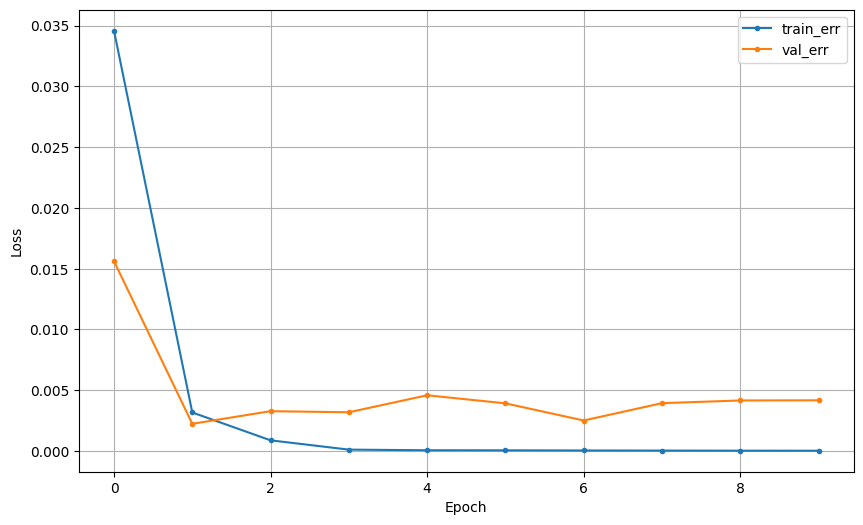

In [27]:
# 학습곡선
dl_history_plot(hist.history)

In [28]:
# 예측 및 평가
y_pred = models[0].predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy_score(y_test, y_pred)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1.0

#### 2) 모델2

In [29]:
models

[<Sequential name=sequential, built=True>]

In [30]:
# 모델 설계
models.append(Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# 컴파일 및 학습
models[1].compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

hist = models[1].fit(X_train, y_train,
                     validation_data=(X_val, y_val),
                     epochs=5)

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9542 - loss: 0.1965 - val_accuracy: 0.9975 - val_loss: 0.0080
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0032 - val_accuracy: 0.9983 - val_loss: 0.0051
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9992 - val_loss: 0.0047
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9997 - loss: 0.0035 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 3.8925e-04 - val_accuracy: 0.9983 - val_loss: 0.0077


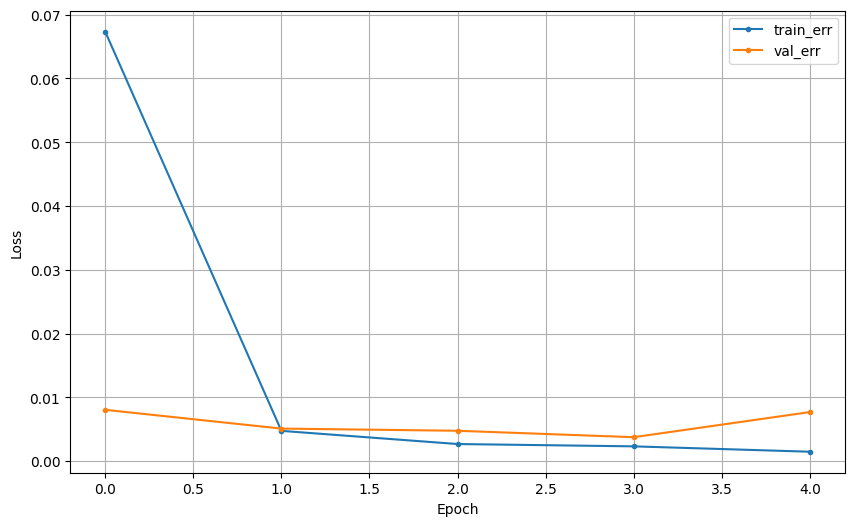

In [32]:
# 학습곡선
dl_history_plot(hist.history)

In [33]:
# 예측 및 평가
y_pred = models[1].predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy_score(y_test, y_pred)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1.0

In [34]:
model_label2 = models[1]

#### 3) 모델3

In [35]:
# 모델 설계
models.append(Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
# 컴파일 및 학습
models[-1].compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [37]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
hist = models[-1].fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=100,
          batch_size=32,
          callbacks=[early_stopping])

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9553 - loss: 0.1638 - val_accuracy: 0.9966 - val_loss: 0.0091
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9994 - loss: 0.0047 - val_accuracy: 0.9992 - val_loss: 0.0043
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9992 - val_loss: 0.0038
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.3368e-04 - val_accuracy: 0.9992 - val_loss: 0.0032
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9975 - loss: 0.0066 - val_accuracy: 0.9992 - val_loss: 0.0040
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 6.7608e-04 - val_accuracy: 0.9992 - val_loss: 0.0048
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.6233e-05 - val_accuracy: 0.9992 - val_loss: 0.0016
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.113

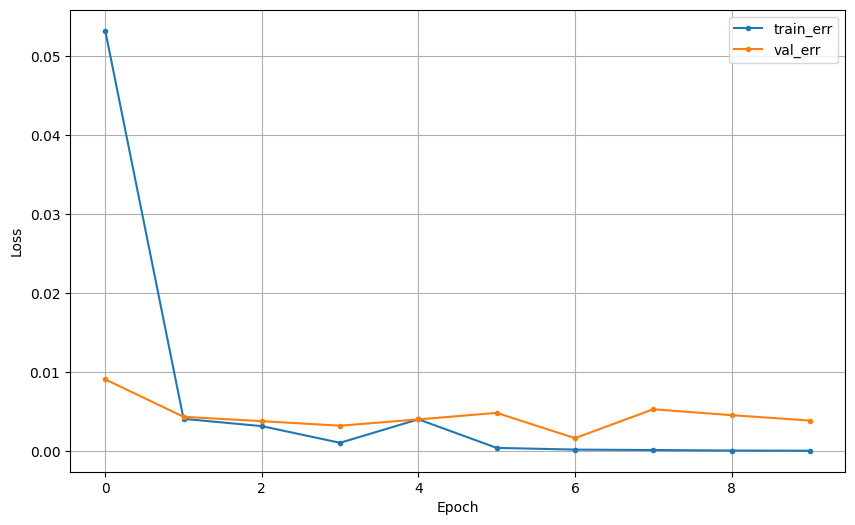

In [38]:
# 학습곡선
dl_history_plot(hist.history)

In [39]:
# 예측 및 평가
y_pred = models[-1].predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy_score(y_test, y_pred)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1.0

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [40]:
# (tip) 정적 행동(0)인 데이터 추출
static_df = train_df[train_df['Activity'].isin(['LAYING', 'SITTING', 'STANDING'])]
static_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,STANDING,0
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,STANDING,0


In [41]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑
static_le = LabelEncoder()
static_df['Activity'] = static_le.fit_transform(static_df['Activity'])
static_df.head()

<ipython-input-41-f7f006654f05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static_df['Activity'] = static_le.fit_transform(static_df['Activity'])


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,2,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,2,0
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,2,0
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,2,0


In [42]:
X = static_df.drop(['Activity', 'is_dynamic'], axis=1)
y = static_df['Activity']

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

In [44]:
# 모델 설계
static_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(static_le.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
# 컴파일 및 학습
static_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist = static_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6365 - loss: 0.7889 - val_accuracy: 0.8686 - val_loss: 0.3430
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8523 - loss: 0.3621 - val_accuracy: 0.8779 - val_loss: 0.2750
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8880 - loss: 0.2671 - val_accuracy: 0.9413 - val_loss: 0.1675
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9111 - loss: 0.2169 - val_accuracy: 0.9490 - val_loss: 0.1431
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9313 - loss: 0.1699 - val_accuracy: 0.9614 - val_loss: 0.1134
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9466 - loss: 0.1457 - val_accuracy: 0.9598 - val_loss: 0.1173
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9337 - loss: 0.1480 - val_accuracy: 0.9227 - val_loss: 0.1805
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9340 - loss: 0.1564 - val_accuracy: 0.9645 - val_loss:

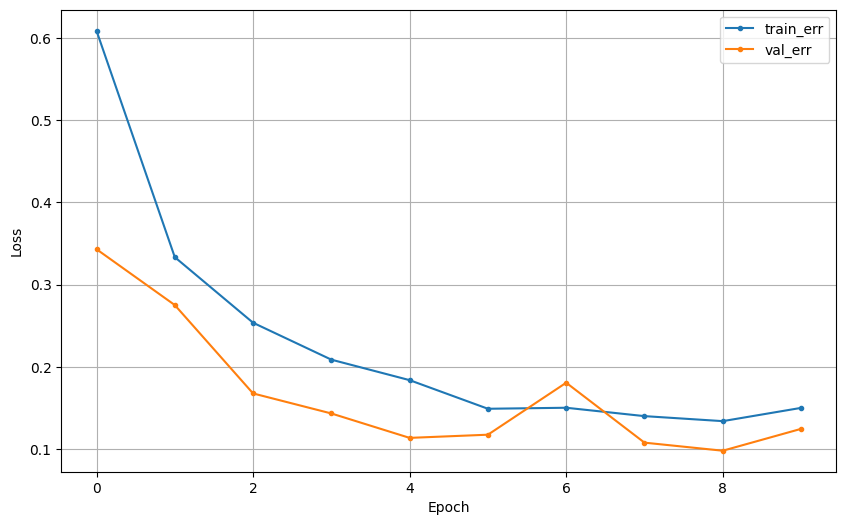

In [46]:
# 학습곡선
dl_history_plot(hist.history)

In [47]:
# 예측 및 평가
test_loss, test_acc = static_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2155 - loss: 2.0650
Test accuracy: 0.21414004266262054


In [63]:
y_pred = static_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy_score(y_test, y_pred)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.2141400407885792

#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [48]:
# (tip) 동적 행동(1)인 데이터 추출
active_df = train_df[train_df['Activity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])]
active_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1
5,0.330708,0.007561,-0.061371,-0.215760,0.101075,0.072949,-0.269857,0.060060,0.101298,-0.019263,...,-0.887024,-0.030645,-0.852091,-0.500195,0.306091,-0.552729,0.253885,0.291256,WALKING_UPSTAIRS,1
6,0.121465,-0.031902,-0.005196,-0.152198,-0.113104,-0.239423,-0.202401,-0.164698,-0.247099,0.114668,...,-0.775779,0.445206,-0.003487,-0.940185,0.041387,-0.886603,0.173338,-0.005627,WALKING,1
12,0.303885,0.002768,-0.038613,-0.168656,0.190336,-0.140473,-0.205134,0.101144,-0.120572,-0.000818,...,-0.329728,-0.040030,0.257252,0.076091,-0.123425,-0.752882,0.266729,0.045692,WALKING,1


In [49]:
# (tip) map 활용해서 숫자레이블로 매핑
active_le = LabelEncoder()
active_df['Activity'] = active_le.fit_transform(active_df['Activity'])
active_df.head()

<ipython-input-49-de19b7715138>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_df['Activity'] = active_le.fit_transform(active_df['Activity'])


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,0,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,1,1
5,0.330708,0.007561,-0.061371,-0.215760,0.101075,0.072949,-0.269857,0.060060,0.101298,-0.019263,...,-0.887024,-0.030645,-0.852091,-0.500195,0.306091,-0.552729,0.253885,0.291256,2,1
6,0.121465,-0.031902,-0.005196,-0.152198,-0.113104,-0.239423,-0.202401,-0.164698,-0.247099,0.114668,...,-0.775779,0.445206,-0.003487,-0.940185,0.041387,-0.886603,0.173338,-0.005627,0,1
12,0.303885,0.002768,-0.038613,-0.168656,0.190336,-0.140473,-0.205134,0.101144,-0.120572,-0.000818,...,-0.329728,-0.040030,0.257252,0.076091,-0.123425,-0.752882,0.266729,0.045692,0,1


In [50]:
# 모델 설계
active_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(active_le.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
# 컴파일 및 학습
active_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist = active_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5112 - loss: 0.9817 - val_accuracy: 0.8331 - val_loss: 0.3693
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8153 - loss: 0.3867 - val_accuracy: 0.8903 - val_loss: 0.2668
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8826 - loss: 0.2946 - val_accuracy: 0.9196 - val_loss: 0.2028
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8953 - loss: 0.2377 - val_accuracy: 0.9413 - val_loss: 0.1701
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9192 - loss: 0.1870 - val_accuracy: 0.9150 - val_loss: 0.1777
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9343 - loss: 0.1580 - val_accuracy: 0.9583 - val_loss: 0.1095
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9378 - loss: 0.1372 - val_accuracy: 0.9614 - val_loss: 0.1002
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9521 - loss: 0.1324 - val_accuracy: 0.9629 - val_loss:

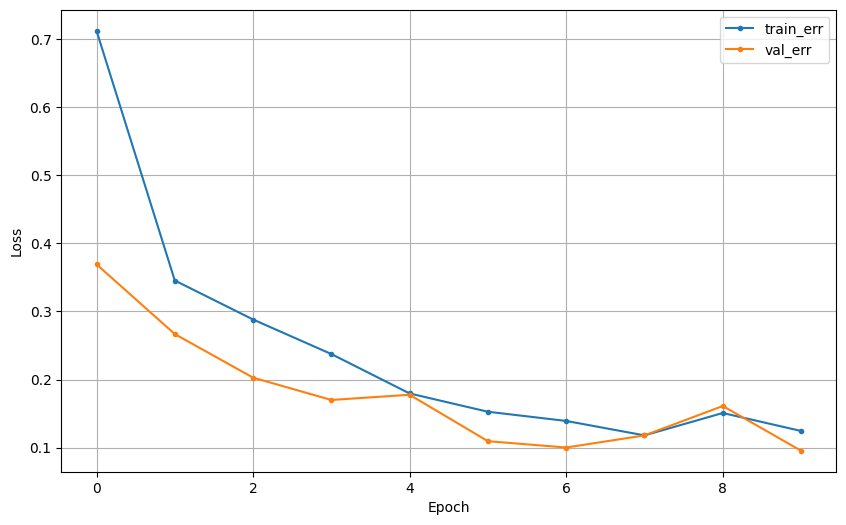

In [52]:
# 학습곡선
dl_history_plot(hist.history)

In [60]:
y_pred = active_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy_score(y_test, y_pred)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


0.22637661454792657

In [53]:
test_loss, test_acc = active_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2284 - loss: 2.0302
Test accuracy: 0.22637660801410675


### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [46]:
#(tip) 함수 만들기
# 1. 전처리
# 1-1. 스케일링
# 1-2. 입력값 만들기
#-------------------
# 2. 예측하기
# 2-1. 단계1을 모델로 0,1 구분
# 2-2. 단계 1의 결과로 데이터 나누기
# 2-3. 단계2 모델로 예측
# 2-4. 예측 결과 원래 값으로 변환
# 2-5. 하나로 합쳐보기
#-------------------
# 3. 최종 성능평가 하기

In [47]:
# (옵션) 위 참고해서 분류모델 파이프라인 만들어보기

In [54]:
# 전처리 함수(DataFrame data를 input으로 받습니다.)
def preprocessing(test_df):
  # is_dynamic 처리
  is_dynamic = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
  test_df['is_dynamic'] = test_df['Activity'].apply(lambda x: 1 if x in is_dynamic else 0)

  # X, y split
  X_test = test_df.drop(['is_dynamic', 'Activity'], axis=1)
  y_test = test_df['is_dynamic']

  # MinMaxScaling
  X_test = scaler.transform(X_test)

  return X_test, y_test

In [55]:
# active / static 예측
def predict_active_or_static(X_test):
  y_pred = models[1].predict(X_test, verbose=0)
  y_pred = np.where(y_pred > 0.5, 1, 0)
  return y_pred

In [56]:
def predict_behavior(y_pred):
  ans = []

  for i, pred in enumerate(y_pred):
    x_input = X_test[i].reshape(1, -1)
    # 정적 행동 분류 모델 예측
    if pred == 0:
      label = static_model.predict(x_input, verbose=0)
      pre = static_le.classes_[np.argmax(label)]
    # 동적 행동 분류 모델 예측
    else:
      label = active_model.predict(x_input, verbose=0)
      pre = active_le.classes_[np.argmax(label)]
    ans.append(pre)
  return ans

In [57]:
# 전체 예측
def predict(test_df):
  # 전처리
  X_test, y_test = preprocessing(test_df)
  # 동/정적 행동 예측
  preds = predict_active_or_static(X_test)
  # 상세 행동 예측
  ans = predict_behavior(preds)
  # 성능평가
  accuracy = accuracy_score(test_df['Activity'], ans)
  print(f'accuracy : {accuracy: .4f}')
  print(classification_report(test_df['Activity'], ans))

#### 2) test 셋으로 예측하고 평가하기

In [52]:
# test 셋의 구조 한번 확인해보고 성능평가 해보기

In [58]:
test_df.shape

(1471, 563)

In [59]:
answer = predict(test_df)

accuracy :  0.6873
                    precision    recall  f1-score   support

            LAYING       0.99      0.99      0.99       292
           SITTING       0.96      0.85      0.91       254
          STANDING       0.89      0.98      0.93       287
           WALKING       0.36      0.82      0.50       228
WALKING_DOWNSTAIRS       0.08      0.02      0.03       195
  WALKING_UPSTAIRS       0.43      0.15      0.23       215

          accuracy                           0.69      1471
         macro avg       0.62      0.64      0.60      1471
      weighted avg       0.67      0.69      0.65      1471

